In [ ]:
def validate_dbscan_parameters(X, eps_values, min_samples_values):
    best_score = -1
    best_eps = None
    best_min_samples = None

    # For each combination of parameters...
    for eps in eps_values:
        for min_samples in min_samples_values:
            # Apply DBSCAN
            db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs = 8)
            labels = db.fit_predict(X)

            # Ignore execution if no clusters were found
            if len(set(labels)) < 2 or -1 not in labels:
                continue

            # Calculate the silhouette score
            score = silhouette_score(X, labels)
            
            if score > best_score:
                best_eps = eps
                best_min_samples = min_samples
                best_score = score

    print(f"Best eps={best_eps}, best min_samples={best_min_samples}, best score={best_score}")

    return best_eps, best_min_samples, best_score

### Exons/5'UTR (SQL)

In [ ]:
db_path = "/data/lvisser/Ensembl/ENS_hsa_105.db"
db = sqlite3.connect(db_path)
c = db.cursor()

In [ ]:
QUERY = "pragma table_info(gene)"
c.execute(QUERY)
gene_colnames = c.fetchall()
print(gene_colnames)

[(0, 'gene_id', 'INTEGER', 1, None, 1), (1, 'biotype', 'varchar(40)', 1, None, 0), (2, 'analysis_id', 'INTEGER', 1, None, 0), (3, 'seq_region_id', 'INTEGER', 1, None, 0), (4, 'seq_region_start', 'INTEGER', 1, None, 0), (5, 'seq_region_end', 'INTEGER', 1, None, 0), (6, 'seq_region_strand', 'INTEGER', 1, None, 0), (7, 'display_xref_id', 'INTEGER', 0, 'NULL', 0), (8, 'source', 'varchar(40)', 1, None, 0), (9, 'description', 'TEXT', 0, None, 0), (10, 'is_current', 'INTEGER', 1, "'1'", 0), (11, 'canonical_transcript_id', 'INTEGER', 1, None, 0), (12, 'stable_id', 'varchar(128)', 0, 'NULL', 0), (13, 'version', 'INTEGER', 0, 'NULL', 0), (14, 'created_date', 'datetime', 0, 'NULL', 0), (15, 'modified_date', 'datetime', 0, 'NULL', 0)]


In [ ]:
QUERY = "select distinct biotype from gene"
c.execute(QUERY)
biotypes = c.fetchall()
print(biotypes)

[('Mt_tRNA',), ('Mt_rRNA',), ('protein_coding',), ('rRNA',), ('lncRNA',), ('processed_pseudogene',), ('snoRNA',), ('polymorphic_pseudogene',), ('unprocessed_pseudogene',), ('transcribed_processed_pseudogene',), ('transcribed_unprocessed_pseudogene',), ('TEC',), ('snRNA',), ('misc_RNA',), ('pseudogene',), ('rRNA_pseudogene',), ('IG_V_pseudogene',), ('TR_V_gene',), ('TR_V_pseudogene',), ('TR_J_gene',), ('TR_C_gene',), ('IG_V_gene',), ('TR_D_gene',), ('unitary_pseudogene',), ('transcribed_unitary_pseudogene',), ('IG_C_gene',), ('IG_D_gene',), ('IG_C_pseudogene',), ('IG_J_gene',), ('IG_J_pseudogene',), ('miRNA',), ('scaRNA',), ('sRNA',), ('TR_J_pseudogene',), ('ribozyme',), ('translated_processed_pseudogene',), ('scRNA',), ('vault_RNA',), ('IG_pseudogene',), ('translated_unprocessed_pseudogene',), ('LRG_gene',)]


In [ ]:
QUERY = """
SELECT * 
FROM gene 
JOIN transcript 
ON gene.canonical_transcript_id = transcript.transcript_id 
JOIN exon_transcript 
ON transcript.transcript_id = exon_transcript.transcript_id 
JOIN translation 
ON exon_transcript.transcript_id = translation.transcript_id 
WHERE gene.biotype = 'protein_coding'
"""
c.execute(QUERY)
protein_coding_genes = c.fetchall()
print(protein_coding_genes[0])

# Get column names from cursor description
column_names = [description[0] for description in c.description]

# Write to TSV file
# with open('query.tsv', 'w', newline='') as f_output:
#     tsv_output = csv.writer(f_output, delimiter='\t')
#     tsv_output.writerow(column_names)  # write header
#     tsv_output.writerows(protein_coding_genes)  # write data

(559, 'protein_coding', 1, 132907, 3307, 4262, 1, 6375858, 'insdc', 'mitochondrially encoded NADH:ubiquinone oxidoreductase core subunit 1 [Source:HGNC Symbol;Acc:HGNC:7455]', 1, 1592, 'ENSG00000198888', 2, '2004-11-24 00:00:00', '2010-01-08 18:00:56', 1592, 559, 1, 132907, 3307, 4262, 1, 6752818, 'insdc', 'protein_coding', '\\N', 1, 941954, 'ENST00000361390', 2, '2004-11-24 00:00:00', '2010-01-08 18:00:56', 5798, 1592, 1, 941954, 1592, 1, 5798, 956, 5798, 'ENSP00000354687', 2, '2004-11-24 00:00:00', '2010-01-08 18:00:56')


In [ ]:
# query_df = pd.read_csv('query.tsv', sep='\t')
# query_df = query_df.filter(regex='^(?:.+\D|\d+)$')
# query_df = query_df.loc[:, ~query_df.columns.str.endswith('.1')]
# print(query_df.shape)
# query_df.head()

In [ ]:
# print(query_df.columns)

#### DBSCAN cluster segmentation

In [ ]:
cpg_dbscan_df = pd.read_csv("/data/lvisser/feature_matrices/concatenated_tables/all_samples/cpg_cat_all_scvg.csv")
print(cpg_dbscan_df.shape)
cpg_dbscan_df.head()

(21342559, 6)


,chrom,ref_position,source_directory,sample_id_adj,cpg_coverage,mod_qual
0,chr15,17082458,data_OHMX20230016R_20231114,IMR14nov_R1,1,0.997070
1,chr15,17082468,data_OHMX20230016R_20231114,IMR14nov_R1,7,0.164760
2,chr15,17082513,data_OHMX20230016R_20231114,IMR14nov_R1,2,0.061523
3,chr15,17082677,data_OHMX20230016R_20231114,IMR14nov_R1,1,0.208008
4,chr15,17082678,data_OHMX20230016R_20231114,IMR14nov_R1,6,0.191406


In [ ]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Initialize an empty DataFrame to store the results
cluster_dbscan_df = pd.DataFrame()

scores = []

best_params = {}

# Define the parameter values that should be searched
eps_values = [3]
min_samples_values = [3]

# Group the DataFrame by 'chrom'
grouped = cpg_dbscan_df.groupby('chrom')

# For each group (i.e., each chromosome), perform DBSCAN clustering
for chrom, group in tqdm(grouped):

    # Get every unique 'ref_position'
    df = group[['ref_position']].drop_duplicates().reset_index(drop=True).sort_values('ref_position')

    # Reshape 'ref_position' to 2D array for the fit method
    X = df['ref_position'].values.reshape(-1, 1)

    # Initialize variables to store the best parameters and the best silhouette score
    best_eps = None
    best_min_samples = None

    # Validate the parameters
    # best_eps, best_min_samples, best_score = validate_parameters(X, eps_values, min_samples_values)

    best_eps = eps_values[0]
    best_min_samples = min_samples_values[0]

    # Apply DBSCAN
    db = DBSCAN(eps = best_eps, min_samples=best_min_samples, n_jobs = 8).fit(X)  # adjust parameters as needed

    # Add cluster labels, chromosome, start and end positions to the DataFrame
    df['cluster'] = db.labels_
    df['chrom'] = chrom
    df['start'] = df.groupby('cluster')['ref_position'].transform('min')
    df['end'] = df.groupby('cluster')['ref_position'].transform('max')
    df['length'] = df['end'] - df['start'] + 1
    df['segment_id'] = df['chrom'].astype(str) + ':' + df['start'].astype(str) + '-' + df['end'].astype(str)

    # Add a column for the number of CpGs in each cluster
    df['num_cpgs'] = df.groupby('segment_id')['ref_position'].transform('count')

    # Create a new column for CpG saturation
    df['cpg_saturation'] = df['num_cpgs'] / df['length']

    # Filter out rows where the cluster label is -1
    df = df[df['cluster'] != -1]

    # Append the results to the results DataFrame
    cluster_dbscan_df = pd.concat([cluster_dbscan_df, df])

# Write the results to a CSV file
cluster_dbscan_df.to_csv("/data/lvisser/segmentations/cluster_dbscan_df.csv", index=False)

100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


In [ ]:
cluster_dbscan_df = pd.read_csv("/data/lvisser/segmentations/cluster_dbscan_df.csv")
print(cluster_dbscan_df.shape)
cluster_dbscan_df.head()

(1066945, 9)


,ref_position,cluster,chrom,start,end,length,segment_id,num_cpgs,cpg_saturation
0,10215,0,chr1,10215,10219,5,chr1:10215-10219,3,0.6
1,10218,0,chr1,10215,10219,5,chr1:10215-10219,3,0.6
2,10219,0,chr1,10215,10219,5,chr1:10215-10219,3,0.6
3,10307,1,chr1,10307,10320,14,chr1:10307-10320,7,0.5
4,10308,1,chr1,10307,10320,14,chr1:10307-10320,7,0.5


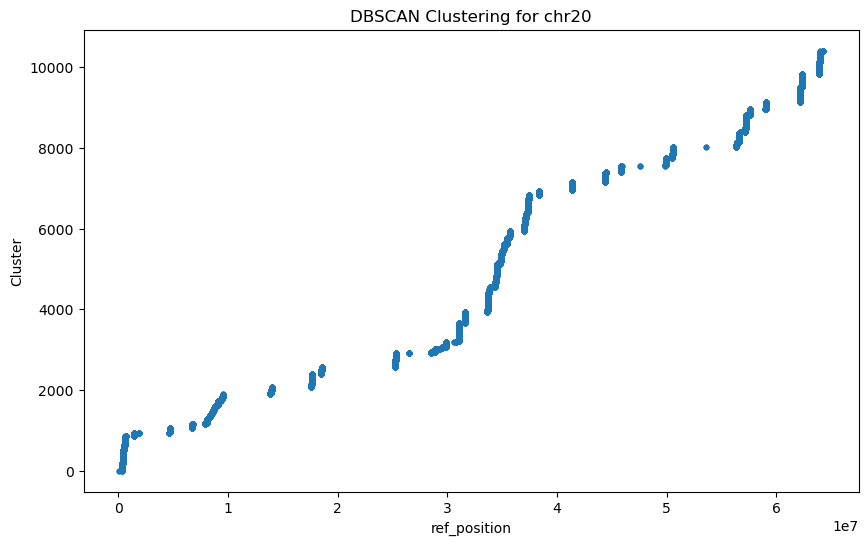

In [ ]:
def plot_clusters_for_chromosome(cluster_dbscan_df, chromosome, covered_positions = None):
    # Filter the DataFrame for the specified chromosome
    df = cluster_dbscan_df[cluster_dbscan_df['chrom'] == chromosome]

    # Create a scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    if covered_positions is not None:
        # Add vertical strips for covered_positions with reduced alpha
        for pos in covered_positions:
            ax.axvspan(pos, pos+1, color='red', alpha=0.1)

    # Scatter plot for cluster_df
    ax.scatter(df['ref_position'], df['cluster'], s=10)

    ax.set_title(f'DBSCAN Clustering for {chromosome}')
    ax.set_xlabel('ref_position')
    ax.set_ylabel('Cluster')

    plt.show()

# Call the function for a specific chromosome
chrom = 'chr20'
covered_positions = cpg_dbscan_df["ref_position"][cpg_dbscan_df["chrom"] == chrom]
plot_clusters_for_chromosome(cluster_dbscan_df, chrom)

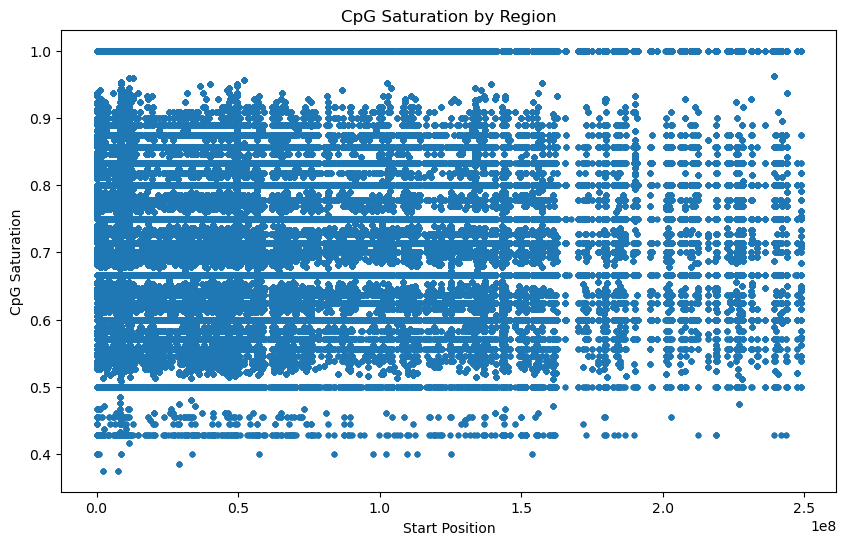

In [ ]:
# Plot the CpG saturation
plt.figure(figsize=(10, 6))
plt.scatter(cluster_dbscan_df['start'], cluster_dbscan_df['cpg_saturation'], s=10)
plt.title('CpG Saturation by Region')
plt.xlabel('Start Position')
plt.ylabel('CpG Saturation')
plt.show()

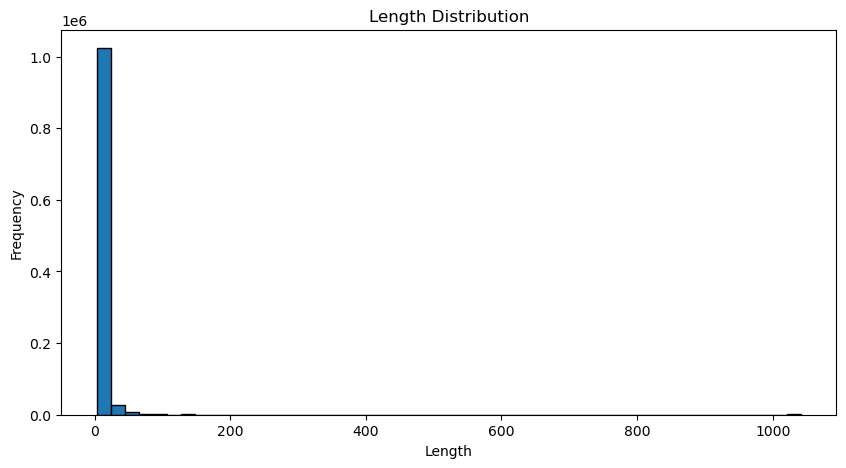

In [ ]:
# Create the plot
plt.figure(figsize=(10, 5))
plt.hist(cluster_dbscan_df['length'], bins=50, edgecolor='black')  # Adjust the number of bins to your needs
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Length Distribution')
plt.show()

In [ ]:
# Merge 'segment_id' from cluster_df into meth_seg
meth_seg_dbscan = cpg_dbscan_df.merge(cluster_dbscan_df[['chrom', 'ref_position', 'segment_id']], how='inner', on=['chrom', 'ref_position'])
meth_seg_dbscan = meth_seg_dbscan.merge(metadata[["sample_id_adj", "Group"]], on = "sample_id_adj", how = "left").drop_duplicates().reset_index(drop = True)
meth_seg_dbscan['avg_methylation'] = meth_seg_dbscan.groupby(["segment_id", "sample_id_adj", "source_directory"])['mod_qual'].transform('mean')

# Add a column for the variance of 'mod_qual' within each 'segment_id'
meth_seg_dbscan['var_methylation'] = meth_seg_dbscan.groupby(["segment_id", "sample_id_adj", "source_directory"])['mod_qual'].transform('var')

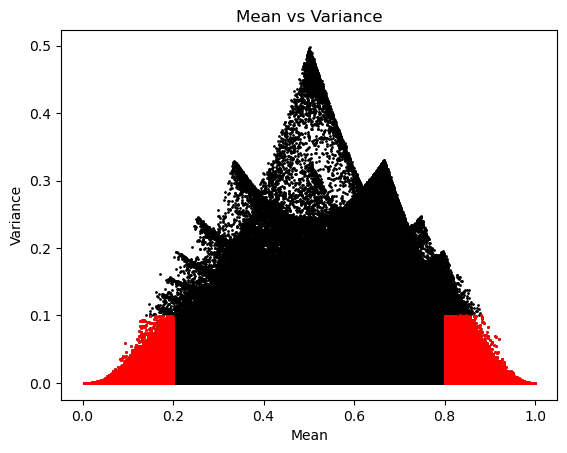

In [ ]:
# Drop duplicates based on 'entropy' and 'mod_qual_variance'
unique_combinations = meth_seg_dbscan[['avg_methylation', 'var_methylation']].drop_duplicates()

# Create a boolean mask for the points to highlight
mask = (unique_combinations['var_methylation'] < 0.1) & ((unique_combinations['avg_methylation'] > 0.8) | (unique_combinations['avg_methylation'] < 0.2))

# Plot all points with smaller size and lighter color
plt.scatter(unique_combinations['avg_methylation'], unique_combinations['var_methylation'], s=1, color='black')

# Plot highlighted points with larger size and darker color
plt.scatter(unique_combinations['avg_methylation'][mask], unique_combinations['var_methylation'][mask], s=1, color='red')

plt.title('Mean vs Variance')
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.show()

In [ ]:
# Define a function that checks if all samples in a group fulfill the requirements
def check_requirements(group):
    return (group['var_methylation'] < 0.1).all() and ((group['avg_methylation'] > 0.8) | (group['avg_methylation'] < 0.2)).all()

# Apply the function to each group
requirements_fulfilled = meth_seg_dbscan.groupby('segment_id').apply(check_requirements, include_groups=False)

# Get the 'segment_id' values for which all samples fulfill the requirements
segment_ids_to_keep = requirements_fulfilled[requirements_fulfilled].index

# Filter the DataFrame to only include these 'segment_id' values
meth_seg_dbscan = meth_seg_dbscan[meth_seg_dbscan['segment_id'].isin(segment_ids_to_keep)]
# Save the DataFrame to a CSV file
meth_seg_dbscan.to_csv("/data/lvisser/feature_matrices/meth_seg_dbscan.csv", index = False)

In [ ]:
meth_seg_dbscan = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_dbscan.csv")
print(meth_seg_dbscan.shape)
meth_seg_dbscan.head()

(1989837, 10)


,chrom,ref_position,source_directory,sample_id_adj,cpg_coverage,mod_qual,segment_id,Group,avg_methylation,var_methylation
0,chr15,25833594,data_OHMX20230016R_20231114,IMR14nov_R1,2,0.986328,chr15:25833594-25833599,S,0.989014,0.000011
1,chr15,25833595,data_OHMX20230016R_20231114,IMR14nov_R1,6,0.988607,chr15:25833594-25833599,S,0.989014,0.000011
2,chr15,25833597,data_OHMX20230016R_20231114,IMR14nov_R1,1,0.987305,chr15:25833594-25833599,S,0.989014,0.000011
3,chr15,25833598,data_OHMX20230016R_20231114,IMR14nov_R1,3,0.993815,chr15:25833594-25833599,S,0.989014,0.000011
4,chr15,31912942,data_OHMX20230016R_20231114,IMR14nov_R1,5,0.850195,chr15:31912942-31912946,S,0.916363,0.008756


In [ ]:
meth_seg_dbscan_fm = create_fm(meth_seg_dbscan, metadata)
meth_seg_dbscan_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_dbscan_fm.csv", index = False)

In [ ]:
meth_seg_dbscan_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_dbscan_fm.csv")
print(meth_seg_dbscan_fm.shape)
meth_seg_dbscan_fm.head()

(8, 68992)


,Group,sample_id_adj,source_directory,chr10:100176847-100176850,chr10:100180609-100180614,chr10:100181804-100181812,chr10:100182320-100182324,chr10:100185414-100185416,chr10:100185742-100185744,chr10:100185842-100185846,...,chrY:11328853-11328860,chrY:56830877-56830879,chrY:56832857-56832893,chrY:56833755-56833759,chrY:56834043-56834051,chrY:56834506-56834517,chrY:56834651-56834661,chrY:56835042-56835048,chrY:56835818-56835823,chrY:56838928-56838935
0,S,IMR14nov_R1,data_OHMX20230016R_20231114,0.913181,0.914562,0.977214,0.922819,0.105794,0.114323,0.125383,...,0.058919,0.091853,0.045294,0.183811,0.028320,0.043229,0.093164,0.095450,0.012695,0.167765
1,S,SHP12dec_R4,data_OHMX20230016R_20231114,0.941894,0.983803,0.991081,0.933804,0.108887,0.119385,0.150282,...,0.053223,0.052214,0.054416,0.070243,0.165365,0.018663,0.023942,0.155707,0.094889,0.092215
2,R,SHY2sept_R1,data_OHMX20230016R_20231114,0.927411,0.945213,0.991249,0.953087,0.108775,0.094347,0.164980,...,0.071289,0.079412,0.113980,0.038783,0.031250,0.081641,0.053277,0.091455,0.037354,0.088381
3,R,SKN14nov_R2,data_OHMX20230016R_20231114,0.910075,0.944351,0.981763,0.959343,0.099447,0.090278,0.100586,...,0.068164,0.038201,0.127575,0.114227,0.059353,0.151774,0.069180,0.067871,0.071661,0.155674
4,R,JJN3_2_1,data_OHMX20230016R_MM_2,0.933582,0.984029,0.969227,0.947469,0.105957,0.093917,0.139920,...,0.070557,0.052257,0.044571,0.057509,0.047201,0.040158,0.026476,0.027344,0.000000,0.048565


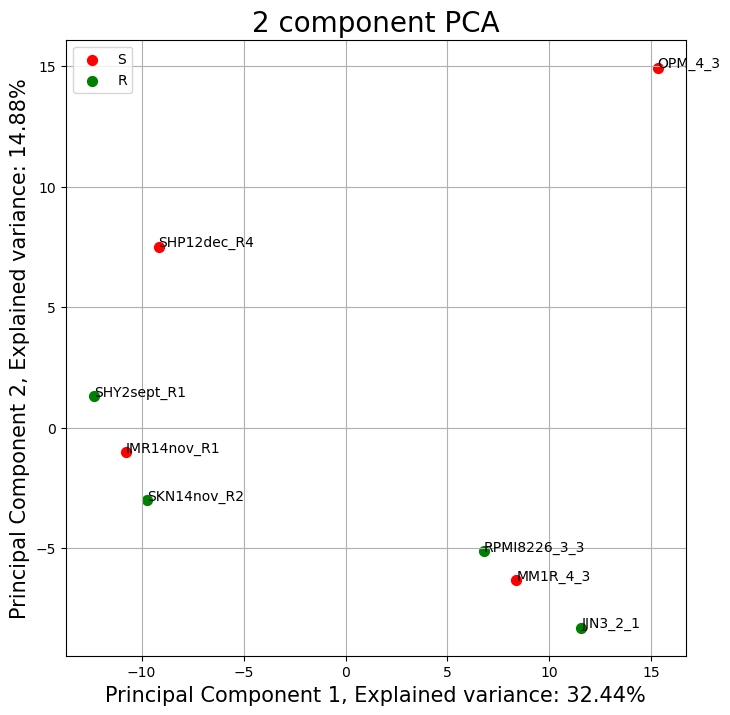

In [ ]:
pca_plot(meth_seg_dbscan_fm, n_components=2, group_column="Group", label_column = "sample_id_adj")

In [ ]:
cpg_wgbstools_test_df = pd.read_csv("/data/lvisser/feature_matrices/concatenated_tables/data_OHMX20230016R_MM_2/cpg_cat_mm1.csv")
print(cpg_wgbstools_test_df.shape)
cpg_wgbstools_test_df.head()

(131106402, 6)


,source_directory,sample_id_adj,ref_position,chrom,cpg_coverage,mod_qual
0,data_OHMX20230016R_MM_2,MM1R_4_3,10118,chr16,2,0.983398
1,data_OHMX20230016R_MM_2,MM1R_4_3,10123,chr16,2,0.995117
2,data_OHMX20230016R_MM_2,MM1R_4_3,10157,chr16,1,0.827148
3,data_OHMX20230016R_MM_2,MM1R_4_3,10158,chr16,1,0.094727
4,data_OHMX20230016R_MM_2,MM1R_4_3,10178,chr16,2,0.562500


In [ ]:
wgbs_seg_train = pd.read_csv("/data/lvisser/feature_matrices/wgbs_seg_nb1.csv")
print(wgbs_seg_train.shape)
wgbs_seg_train.head()

(1895562, 5)


,IMR14nov_R1,SHP12dec_R4,SHY2sept_R1,SKN14nov_R2,segment_id
0,0.88,0.04,0.04,0.06,chr22:10510235-10512049
1,0.92,0.02,0.08,0.07,chr22:10513853-10515736
2,1.00,0.15,0.00,0.00,chr22:10516017-10517750
3,1.00,0.00,0.00,0.09,chr22:10518304-10520219
4,NaN,0.11,0.00,0.06,chr22:10520752-10522650


In [ ]:
wgbs_dmr_train = pd.read_csv("/data/lvisser/feature_matrices/wgbs_dmr_nb1.csv")
print(wgbs_dmr_train.shape)
wgbs_dmr_train.head()

(37200, 18)


,chrom,start,end,startCpG,endCpG,target,segment_id,lenCpG,bp,tg_mean,bg_mean,delta_means,delta_quants,delta_maxmin,ttest,direction,gene_symbol,length
0,chr8,339324,339424,12448810,12448816,R,chr8:339324-339424,6CpGs,100bp,0.1650,0.746,0.581,0.457,0.404,0.0442,U,none,100
1,chr8,636727,636822,12453158,12453162,R,chr8:636727-636822,4CpGs,95bp,0.3810,0.882,0.501,0.471,0.446,0.0091,U,none,95
2,chr8,1373259,1373562,12470337,12470371,R,chr8:1373259-1373562,34CpGs,303bp,0.0185,0.813,0.794,0.707,0.693,0.0111,U,none,303
3,chr8,1956798,1957098,12483994,12484007,R,chr8:1956798-1957098,13CpGs,300bp,0.1170,0.909,0.792,0.684,0.658,0.0157,U,none,300
4,chr8,1958036,1958341,12484025,12484039,R,chr8:1958036-1958341,14CpGs,305bp,0.0329,0.607,0.574,0.503,0.499,0.0160,U,none,305


In [ ]:
meth_seg_wgbs_test = cpg2segment_aggregation_trees(cpg_wgbstools_test_df, wgbs_dmr_train[["chrom", "start", "end", "segment_id", "gene_symbol", "length"]].copy())
meth_seg_wgbs_test.to_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_test.csv", index = False)

initializing meth_seg...


Aggregating: 100%|██████████| 92/92 [39:40<00:00, 25.87s/it]  


In [ ]:
meth_seg_wgbs_test = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_test.csv")
meth_seg_wgbs_test['positions'] = meth_seg_wgbs_test['positions'].apply(ast.literal_eval)
meth_seg_wgbs_test['mod_qual_positions'] = meth_seg_wgbs_test['mod_qual_positions'].apply(ast.literal_eval)
print(meth_seg_wgbs_test.shape)
meth_seg_wgbs_test.head()

(148800, 11)


,sample_id_adj,segment_id,source_directory,total_methylation,positions,mod_qual_positions,num_cpgs,avg_methylation,gene_symbol,length,chrom
0,MM1R_4_3,chr10:100008393-100008824,data_OHMX20230016R_MM_2,7.887695,"[100008400, 100008576, 100008647, 100008672, 1...","[0.9951172, 0.9638672, 0.9970703, 0.9482422, 0...",8,0.985962,none,431,chr10
1,OPM_4_3,chr10:100008393-100008824,data_OHMX20230016R_MM_2,16.110352,"[100008393, 100008399, 100008400, 100008480, 1...","[0.9638672, 0.99804687, 0.85253906, 0.66829427...",18,0.895020,none,431,chr10
2,JJN3_2_1,chr10:100008393-100008824,data_OHMX20230016R_MM_2,6.283887,"[100008393, 100008399, 100008400, 100008480, 1...","[0.9970703, 0.0465494796666666, 0.9970703, 0.0...",16,0.392743,none,431,chr10
3,RPMI8226_3_3,chr10:100008393-100008824,data_OHMX20230016R_MM_2,5.843750,"[100008393, 100008399, 100008400, 100008480, 1...","[0.99316406, 0.99902344, 0.9970703, 0.9658203,...",6,0.973958,none,431,chr10
4,RPMI8226_3_3,chr10:100358798-100359877,data_OHMX20230016R_MM_2,16.152474,"[100358798, 100358841, 100358842, 100358851, 1...","[0.9951171933333334, 0.9069475457142856, 0.984...",17,0.950146,none,1079,chr10


In [ ]:
meth_seg_wgbs_train_fm = wgbs_seg_train.set_index('segment_id')
meth_seg_wgbs_train_fm = meth_seg_wgbs_train_fm[meth_seg_wgbs_train_fm.index.isin(wgbs_dmr_train["segment_id"])].T

# Reset the index and rename it to 'sample_id_adj'
meth_seg_wgbs_train_fm.reset_index(inplace=True)
meth_seg_wgbs_train_fm = meth_seg_wgbs_train_fm.rename(columns={'index': 'sample_id_adj'})

common_columns = meth_seg_wgbs_train_fm.columns[meth_seg_wgbs_train_fm.columns.isin(meth_seg_wgbs_test["segment_id"])]
selected_columns = ["sample_id_adj"] + common_columns.tolist()
meth_seg_wgbs_train_fm = meth_seg_wgbs_train_fm[selected_columns].merge(metadata[["sample_id_adj", "source_directory", "Group"]], on = "sample_id_adj", how = "left").drop_duplicates().reset_index(drop = True)
meth_seg_wgbs_train_fm.head()

,sample_id_adj,chr22:10525749-10525908,chr22:10525917-10525931,chr22:10526088-10526122,chr22:10526193-10526215,chr22:10572052-10572175,chr22:10673829-10673875,chr22:10842775-10844527,chr22:11264810-11264865,chr22:11269304-11269717,...,chr9:137352331-137352614,chr9:137373511-137373886,chr9:137377887-137378036,chr9:137454945-137455106,chr9:137458125-137458168,chr9:137682690-137682860,chr9:138203285-138203331,chr9:138234518-138234560,source_directory,Group
0,IMR14nov_R1,0.97,1.00,1.00,1.00,0.99,1.00,0.93,0.74,0.94,...,1.00,0.95,0.92,0.58,0.75,0.85,0.11,0.80,data_OHMX20230016R_20231114,S
1,SHP12dec_R4,0.96,0.89,0.92,0.92,0.89,0.87,1.00,0.75,0.73,...,0.88,0.95,1.00,0.75,1.00,1.00,0.00,0.79,data_OHMX20230016R_20231114,S
2,SHY2sept_R1,0.56,0.34,0.11,0.35,0.46,0.40,0.17,0.23,0.11,...,0.46,0.45,0.50,0.00,0.15,0.36,0.67,0.38,data_OHMX20230016R_20231114,R
3,SKN14nov_R2,0.59,0.17,0.18,0.07,0.58,0.33,0.13,0.30,0.24,...,0.47,0.41,0.48,0.02,0.12,0.43,0.57,0.25,data_OHMX20230016R_20231114,R


In [ ]:
def validate_dbscan_parameters(X, eps_values, min_samples_values):
    best_score = -1
    best_eps = None
    best_min_samples = None

    # For each combination of parameters...
    for eps in eps_values:
        for min_samples in min_samples_values:
            # Apply DBSCAN
            db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs = 8)
            labels = db.fit_predict(X)

            # Ignore execution if no clusters were found
            if len(set(labels)) < 2 or -1 not in labels:
                continue

            # Calculate the silhouette score
            score = silhouette_score(X, labels)
            
            if score > best_score:
                best_eps = eps
                best_min_samples = min_samples
                best_score = score

    print(f"Best eps={best_eps}, best min_samples={best_min_samples}, best score={best_score}")

    return best_eps, best_min_samples, best_score

In [ ]:
meth_seg_wgbs_test_fm = create_fm(meth_seg_wgbs_test, metadata)
meth_seg_wgbs_fm = pd.concat([meth_seg_wgbs_train_fm, meth_seg_wgbs_test_fm])
meth_seg_wgbs_fm = meth_seg_wgbs_fm.dropna(axis=1)
meth_seg_wgbs_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_fm.csv", index = False)

In [ ]:
meth_seg_wgbs_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_fm.csv")
print(meth_seg_wgbs_fm.shape)
meth_seg_wgbs_fm.head()

(8, 37184)


,sample_id_adj,chr22:10525749-10525908,chr22:10525917-10525931,chr22:10526088-10526122,chr22:10526193-10526215,chr22:10572052-10572175,chr22:10673829-10673875,chr22:10842775-10844527,chr22:11264810-11264865,chr22:11269304-11269717,...,chr9:137352331-137352614,chr9:137373511-137373886,chr9:137377887-137378036,chr9:137454945-137455106,chr9:137458125-137458168,chr9:137682690-137682860,chr9:138203285-138203331,chr9:138234518-138234560,source_directory,Group
0,IMR14nov_R1,0.970000,1.00000,1.000000,1.000000,0.990000,1.000000,0.930000,0.740000,0.940000,...,1.000000,0.950000,0.920000,0.580000,0.750000,0.850000,0.110000,0.800000,data_OHMX20230016R_20231114,S
1,SHP12dec_R4,0.960000,0.89000,0.920000,0.920000,0.890000,0.870000,1.000000,0.750000,0.730000,...,0.880000,0.950000,1.000000,0.750000,1.000000,1.000000,0.000000,0.790000,data_OHMX20230016R_20231114,S
2,SHY2sept_R1,0.560000,0.34000,0.110000,0.350000,0.460000,0.400000,0.170000,0.230000,0.110000,...,0.460000,0.450000,0.500000,0.000000,0.150000,0.360000,0.670000,0.380000,data_OHMX20230016R_20231114,R
3,SKN14nov_R2,0.590000,0.17000,0.180000,0.070000,0.580000,0.330000,0.130000,0.300000,0.240000,...,0.470000,0.410000,0.480000,0.020000,0.120000,0.430000,0.570000,0.250000,data_OHMX20230016R_20231114,R
4,JJN3_2_1,0.713838,0.75784,0.489852,0.534078,0.587559,0.691768,0.097284,0.186686,0.549606,...,0.136623,0.579082,0.552176,0.545654,0.951497,0.904004,0.126031,0.795201,data_OHMX20230016R_MM_2,R


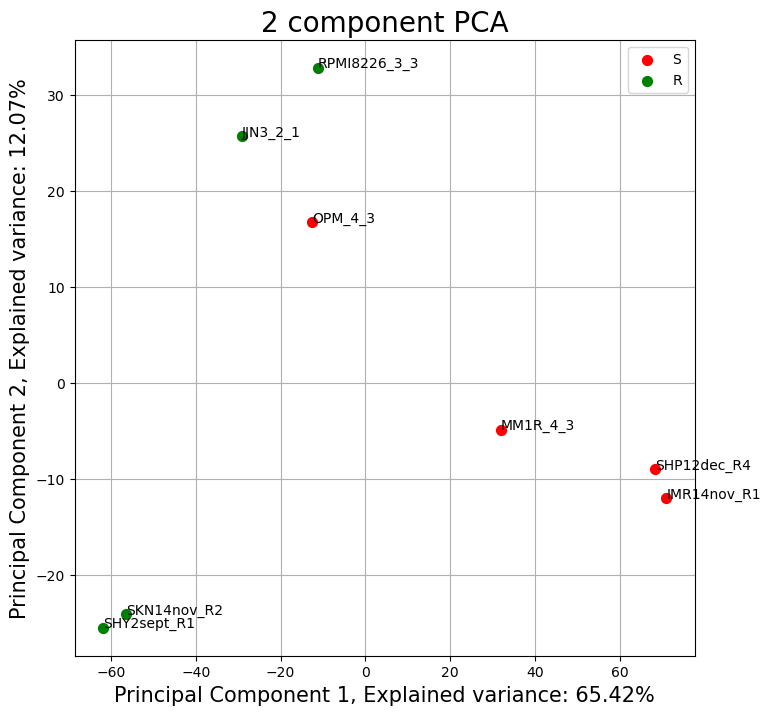

In [ ]:
pca_plot(meth_seg_wgbs_fm, n_components=2, group_column="Group", label_column = "sample_id_adj")

In [ ]:
meth_seg_dbscan_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_dbscan_fm.csv")

DMR has removed 34626 features of the original 68989.
Regularization has removed 31597 features of the original 34363.
Sample: 0
Cell line: IMR14nov_R1
True label: S
Predicted label: R
Probabilities:
['R']: 0.6248753479157435
['S']: 0.3751246520842565

Sample: 1
Cell line: SHP12dec_R4
True label: S
Predicted label: R
Probabilities:
['R']: 0.6131697491178307
['S']: 0.3868302508821693

Sample: 2
Cell line: SKN14nov_R2
True label: R
Predicted label: R
Probabilities:
['R']: 0.5635407616724539
['S']: 0.436459238327546

Sample: 3
Cell line: MM1R_4_3
True label: S
Predicted label: R
Probabilities:
['R']: 0.5604087399500766
['S']: 0.4395912600499235

PCA after filtering:


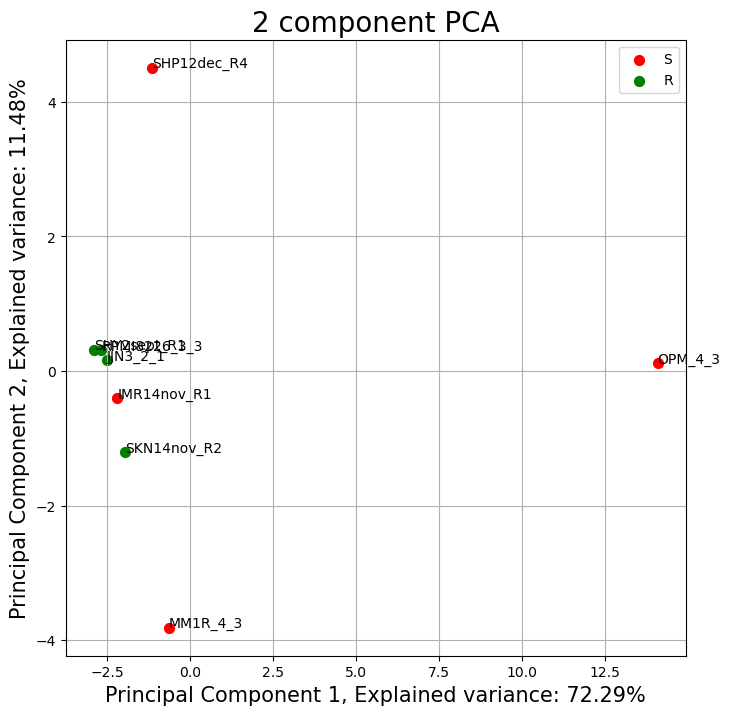

In [ ]:
model, importances_df = train_and_predict_single(meth_seg_dbscan_fm, test_size = 0.5, reg = True, dmr = 'ttest')

In [ ]:
train_and_predict_loo(meth_seg_dbscan_fm, reg = True, dmr = 'ttest')

KeyboardInterrupt: 